# Past cropping outcomes

Code to make final figure for manuscript on past cropping outcomes: crop failure and yield.

Last updated: 9 November 2020

**Goal:** Extract alphas, lambdas from 1930s and 2010s climatology

Followed Kelly's steps on Slack:

<img src="files/methods_sketch.png" style="width: 600px">

1. The blue lines in each plot represent the average annual change in either parameter over the period of observation.
2. We can use the entire record to get an estimate of the alpha and lambda for each decad (let’s call this the “seasonally-varying” component of climate, which is determined by the ITCZ, etc…)
3. Those average decad values would correspond to the typical climate in the middle of the record.
4. To get at the recent (or past) values, we just apply the trend line to each of the individual average decads to see what the “2020” or “1940" values would be.

For example:
alpha_decad_1(1940) = average_alpha_decad_1  d_seasonal_alpha/dt * 30 years
(assuming the middle of the observation period is 1970)
d_seasonal_alpha/dt  is the slope of the blue line for seasonal alpha. 

We use the long-term seasonal trends for each parameter to adjust the long-term average values for each decad in order to obtain historical (or future) values of the parameters in each decad.


In [1]:
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st
from statistics import mean 

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *
from farm.climate import make_climate_parameters, check_exponential, Climate

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

## Steps:

#### 1. The blue lines in each plot represent the average annual change in either parameter over the period of observation.

These values are from the trend graphs in `1-rainfall-variability-stats`.

In [2]:
# Make a plot of the slopes for Jacobson Farm for alpha and lambda
t = pd.Series(np.arange(1934, 2015, 1))

# Import these trends but based on 5 month parameters (This is taking the average of the long rains and short rains)
m_a = 0.066401 # Slope, alpha
m_l = -0.002440 # Slope, lambda

c_a = -122.684507 # Intercept, alpha
c_l = 5.163470 # Intercept, lambda

#### 2. We can use the entire record to get an estimate of the alpha and lambda for each decad (let’s call this the “seasonally-varying” component of climate, which is determined by the ITCZ, etc…)

Seasonally varying component = alpha and lambdas as they stand normally in the code.

In [3]:
# This is for Jacobson Farm
station = 'JACOBSON FARM'
interval='dekad'
data_file="../data/CETRAD/CETRAD_rainfall.csv"

a_mid, l_mid, sd = make_climate_parameters(data_file = data_file, station=station, interval=interval) 

# Make a dataframe with these alphas and lambdas
# These will be our alphas and lambdas for the middle of the time series                                                                              ]})
df_mid = pd.DataFrame({'alpha':a_mid, 'lambda':l_mid, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})

#### 3. Those average decad values would correspond to the typical climate in the middle of the record.

Use those values for alpha, `a_mid`, and lambda, `l_mid`, as the typical climate in the middle of the record. Run the models.

In [4]:
def run(alpha_r=None, lambda_r=None, n_sim = 10000, burn_in = 60,  station = 'JACOBSON FARM', data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
    texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad', do_std=True):
    """ Set up model conditions for model runs. 
    
    
    Usage: run(n_sim, burn_in, station, data_file, texture, lgp, pd_sim, interval)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [days]
        pd_sim 100 # Planting Date for Simulation [day of year]
        data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv' # Location of Rainfall Data [csv file]
        interval = 'dekad' # Time interval to calculate alpha and lambda parameters [string]

    """
    ## Step 1: Run model
    # Part 1. Set conditions for IC runs
    doy = pd_sim - burn_in
    while doy < 1:
        doy = 365 + doy
    
    print("Step 1: \n\t...Conducting burn in starting at doy {doy}, which is {burn_in} days before the simulated planting date of {pd_sim}.".format(
        doy=doy,
        burn_in=burn_in,
        pd_sim=pd_sim)
    )
    
    # Part 2. Initialize model with a climate, soil and crop
    print("Step 2: \n\t...Initializing {interval} lamba and alphas based on {station} using {data_file}.".format(
        interval=interval,
        station=station,
        data_file=data_file)
    )
    
    s0_climate = Climate(
        data_file=data_file,
        station=station,
        interval=interval,
        alpha_r = alpha_r,
        lambda_r = lambda_r,
        #alpha_r=[100]*37, lambda_r=[0.5]*37, # For some reason, this isn't affected.
        # maybe this isn't affected because it's just changing the initial soil moisture?
        do_std=False) # This should be false, always
    
    print("\t...Initializing soil as {texture}".format(texture=texture))
    soil = Soil(texture=texture)
    
    print("\t...Initializing crop with {lgp} days to maturity".format(lgp=lgp))
    crop = Crop(soil=soil, lgp=lgp)
    
    print("\t...Setting nZr parameter to {nZr}".format(nZr=soil.set_nZr(crop)))
    soil.set_nZr(crop)
    
    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    
    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    n_burn_in_sims = max(10, int(n_sim*.10))
    print("Step 3: \n\t... Setting number of burn in simulations to {n_burn_in_sims}".format(
        n_burn_in_sims=n_burn_in_sims)
    )
    
    print("\t...Computing average soil moisture for doy {doy} using {n_sim} simulations".format(
        doy=doy,
        n_sim=n_burn_in_sims)
    )
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_burn_in_sims, doy=doy)
    print("\t\t[s0_mean]:{s0_mean}\t[s0_std]:{s0_std}".format(
        s0_mean=s0_mean,
        s0_std=s0_std)
    )
    models = [CropModel(
                  crop=crop,
                  climate=Climate( # this one is affected. 
                      alpha_r= alpha_r, #previously s0_climate.alpha_r, 
                      # when I changed alpha_r to [100]*37, this definitely changed things!!!
                      lambda_r= lambda_r, #s0_climate.lambda_r, # [0.5]*37,
                      lambda_std=s0_climate.lambda_std,
                      do_std=True),
                  soil=soil) for i in np.arange(n_sim)
               ]
    
    # Part 4. Run the actual simulations 
    print("Step 4: \n\t... Running {n_sim} simulations.".format(n_sim=n_sim))
    # We imported printProgressBar from functions.py earlier:
    printProgressBar(0, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    output = []
    for i, model in enumerate(models):
        output.append(model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim))
        printProgressBar(i + 1, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    #output = [model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim) for model in models]

    print("\t... Done.")

    # Part 5. Subset the growing period and get avg soil moisture
    print("Step 5: \n\t...Subsetting data to growing period.")
 
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output] # Made a change here, I dont think this makes a diff.
    
    # Part 6. Output the dynamic stress and yield values
    print("Step 6: \n\t...Calculating plant stress.")

    x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(dtm=lgp)) for df in output] # Made a change here
    
    rf = [df[start:end]['R'].sum() for df in output] # made a change here
    
    return x, rf, int(lgp), avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in

In [5]:
x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(
    alpha_r =a_mid, lambda_r= l_mid, n_sim=10000) # 
    #alpha_r=a_mid, lambda_r=l_mid, n_sim=10000
    #alpha_r =a_mid, lambda_r= l_mid
    
# This should actually work 

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on JACOBSON FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.6430668293100159	[s0_std]:0.057665016805797775
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [6]:
# put into dataframe
result = pd.DataFrame.from_records(x, columns =['AvgStress','DynamicStress','Yield'])
result['RF'] = rf

# For catting them all together
result['Era'] = 'mid'

#### 4. To get at the recent (or past) values, we just apply the trend line to each of the individual average decads to see what the “2020” or “1940" values would be.



In [7]:
# There are 80 years in the record (1934-2014), so we'll add or subtract by 40 years.
# df_mid corresponds to the alpha and lambdas we use for the middle or average values
# previously used m_al, m_ll but now can just use m_l and m_a

alphas_2010 = df_mid['alpha']+m_a*40; alphas_2010
alphas_1930 = df_mid['alpha']-m_a*40; alphas_1930

lambdas_2010 = df_mid['lambda']+m_l*40; lambdas_2010 
lambdas_1930 = df_mid['lambda']-m_l*40

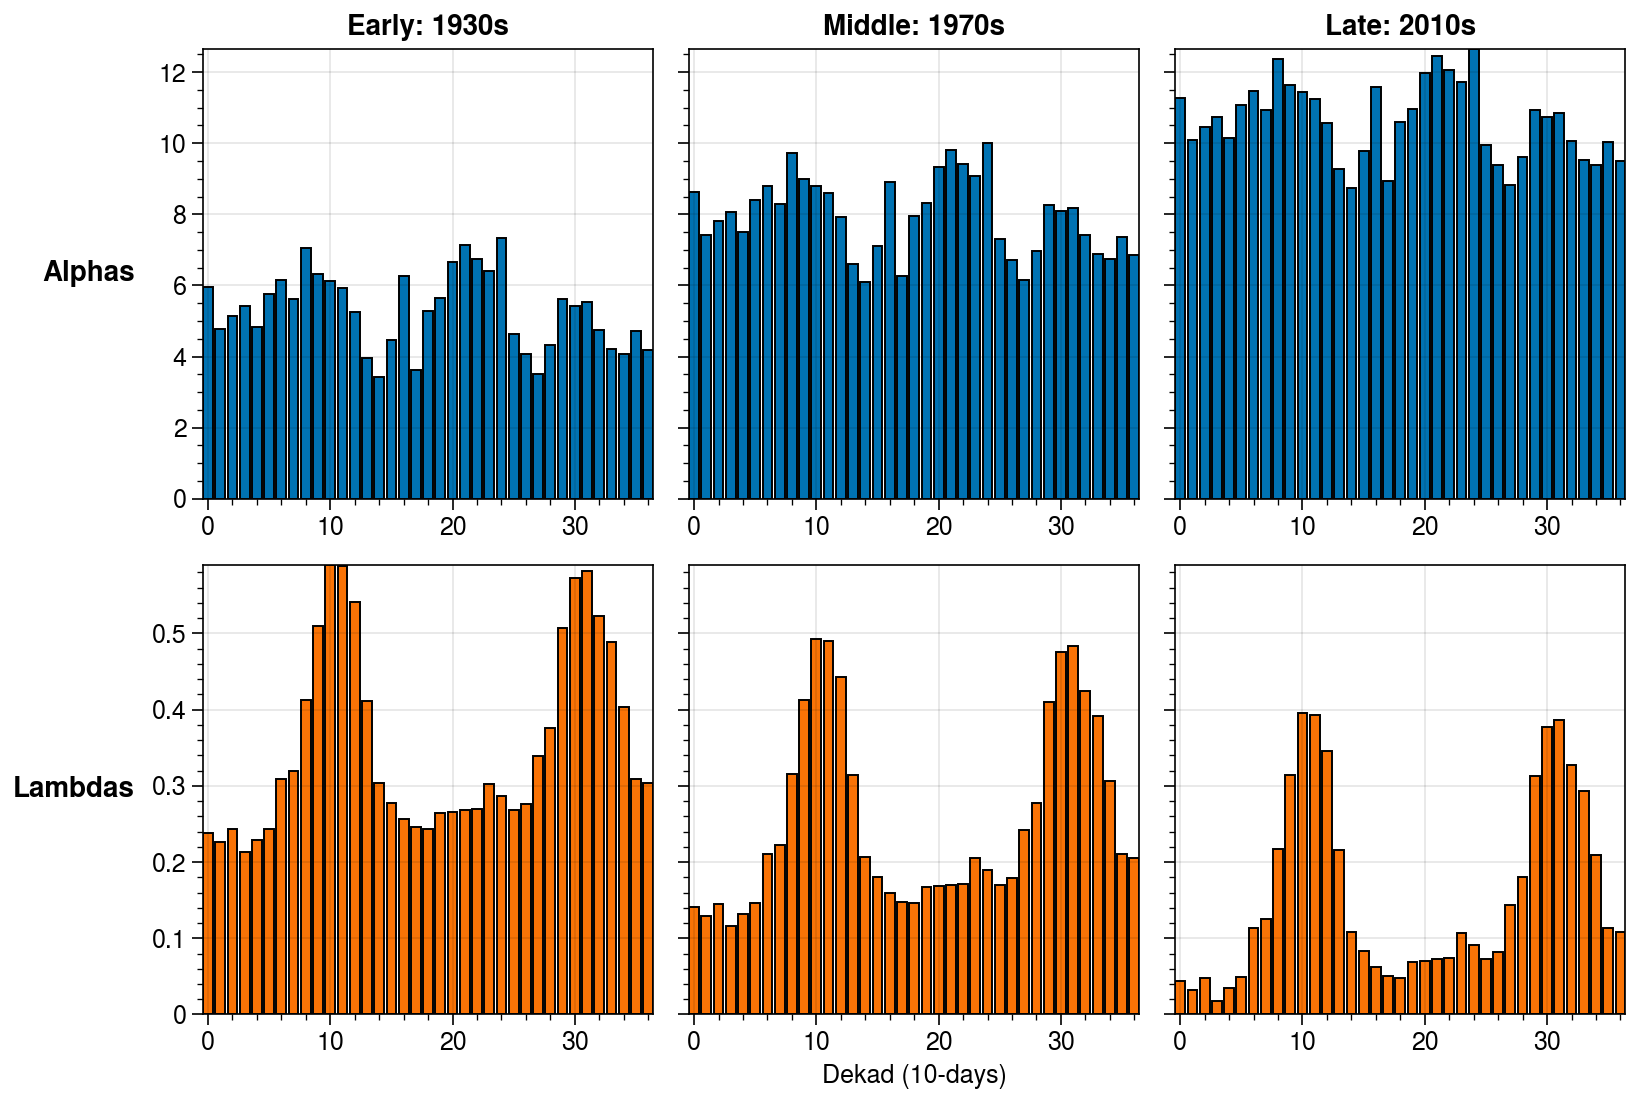

In [8]:
# Make three bar subplots of the deakadal alphas and lambdas
f, ax = plot.subplots(nrows=2, ncols=3, sharex=True) # , sharey=1

ax.format(
    rowlabels=['Alphas', 'Lambdas'],
    collabels=['Early: 1930s', 'Middle: 1970s', 'Late: 2010s']
)

ax[0,0].bar(alphas_1930)
ax[0,1].bar(df_mid.alpha)
ax[0,2].bar(alphas_2010)

ax[1,0].bar(lambdas_1930, color='orange')
ax[1,1].bar(df_mid['lambda'], color='orange')
ax[1,2].bar(lambdas_2010, color='orange')

# Good ol labels
#ax[0:].format(ylabel='Avg. depth per storm (mm)')
#ax[1:].format(ylabel='Inter-storm arrival rate (day^-1)')
ax[:3:2].format(xlabel='Dekad (10-days)')
ax[1:].format(ylabel='')

In [9]:
# Run the sims for 2010
x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(alpha_r=alphas_2010, 
    lambda_r=lambdas_2010,n_sim=10000)

# put into dataframe
result_2010 = pd.DataFrame.from_records(x, columns =['AvgStress','DynamicStress','Yield'])
result_2010['RF'] = rf
result_2010['Era'] = 'late'

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on JACOBSON FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.639595844505432	[s0_std]:0.05636286001265985
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [10]:
# Run the sims for 1930s
x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(
    alpha_r=alphas_1930, lambda_r=lambdas_1930,n_sim=10000
       )

# put into dataframe
result_1930 = pd.DataFrame.from_records(x, columns =['AvgStress','DynamicStress','Yield'])
result_1930['RF'] = rf
result_1930['Era'] = 'early'

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on JACOBSON FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.641637599808147	[s0_std]:0.05535007012097895
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [14]:
# Cat the three dataframes together
result_list = [result_1930, result, result_2010]
result_list = pd.concat(result_list)

In [20]:
# Do table and plot

def make_table(df = None):
    
    r_1930 = df.query('Era == "early"')
    r_avg = df.query('Era == "mid"')
    r_2010 = df.query('Era == "late"')
    
    table = pd.DataFrame({'Rainfall Climatology':['Early: 1930s','Middle: 1970s (Avg)','Late: 2010s'],
                       # 'Rainfall Climatology':['1935-1940','1972-1977','2010-2015']
                'Maize Variety':[180,180,180],
                'Average Alpha (mm)':[mean(alphas_1930), mean(a_mid), mean(alphas_2010)],
                'Average Lambda (day^-1)':[mean(lambdas_1930), mean(l_mid), mean(lambdas_2010)],
                
                'Average Rainfall (mm)':[r_1930.RF.mean(), r_avg.RF.mean(), r_2010.RF.mean()],
                          
                'SD Rainfall':[np.std(r_1930.RF),np.std(r_avg.RF),np.std(r_2010.RF)],
                          
                'CV Rainfall':[r_1930.RF.std()/r_1930.RF.mean(), 
                                    r_avg.RF.std()/r_avg.RF.mean(),
                                    r_2010.RF.std()/r_2010.RF.mean()],
                'Average Yield (t/ha)': [np.nanmean(r_1930.Yield), 
                                         np.nanmean(r_avg.Yield), 
                                         np.nanmean(r_2010.Yield)],
                'Probability of Crop Failure (%)':[len(r_1930.loc[r_1930['Yield'] == 0].count(axis=1))/len(r_1930)*100,
                                                   len(r_avg.loc[r_avg['Yield'] == 0].count(axis=1))/len(r_avg)*100,
                                                   len(r_2010.loc[r_2010['Yield'] == 0].count(axis=1))/len(r_2010)*100]})
    return table

table = make_table(result_list); table

,Rainfall Climatology,Maize Variety,Average Alpha (mm),Average Lambda (day^-1),Average Rainfall (mm),SD Rainfall,CV Rainfall,Average Yield (t/ha),Probability of Crop Failure (%)
0,Early: 1930s,180,5.309345,0.351547,362.173476,140.287840,0.387369,0.953190,38.71
1,Middle: 1970s (Avg),180,7.965385,0.253947,387.600888,152.935602,0.394590,1.121464,26.82
2,Late: 2010s,180,10.621425,0.156347,317.471095,135.046644,0.425404,0.767335,33.85


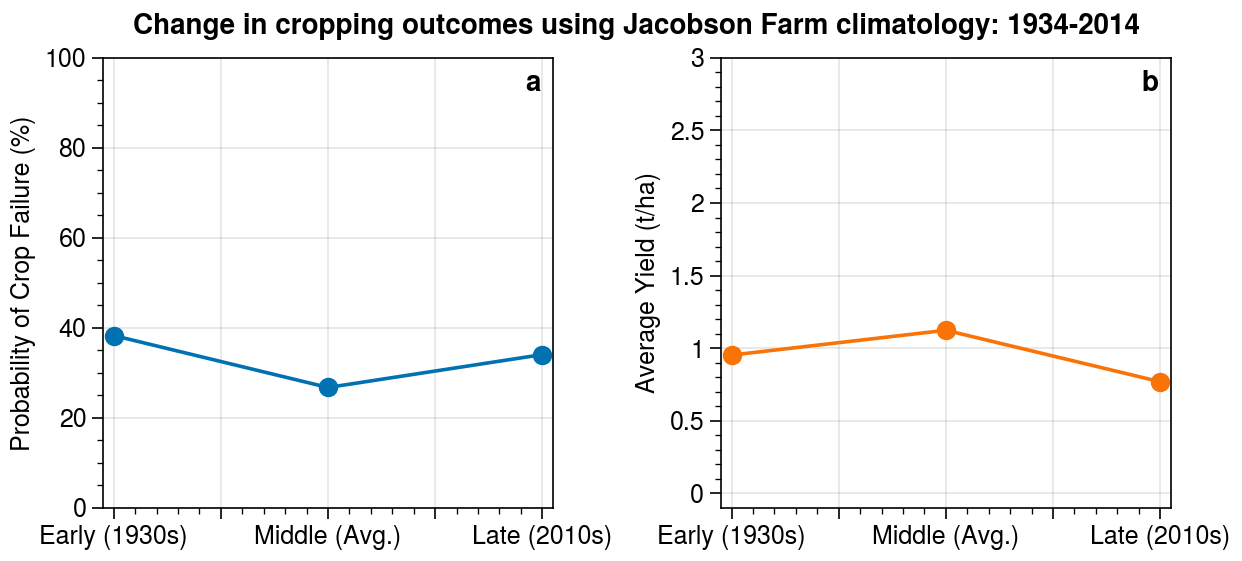

In [28]:
# Make final figure for manuscript

def make_fig(table = None): 
    f, ax = plot.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
    ax.format(
             suptitle='Change in cropping outcomes using Jacobson Farm climatology: 1934-2014',
             #title='reference', titleweight='bold',
             #titleloc='uc', titlecolor='red9'
            abc=True, abcloc='ur' # xlabel='Year', 
         )

    # Consider adding some kind of error bar: yerr=df['Probability of Crop Failure (%)']
    table['Probability of Crop Failure (%)'].plot(marker='o',markersize=6, ax=ax[0])
    ax[0].set(ylim=(0,100))
    ax[0].format(ylabel='Probability of Crop Failure (%)')
    ax[0].set(xlim=(-0.05,2.05))
    ax[0].set_xticklabels(['','Early (1930s)', '',
                          'Middle (Avg.)','','Late (2010s)'])

    table['Average Yield (t/ha)'].plot(marker='o',markersize=6, ax=ax[1], color='orange')
    ax[1].set(ylim=(-0.1,3))
    ax[1].set(xlim=(-0.05,2.05))
    #ax[1].set(ylabel='Average Yield (t/ha)')
    ax[1].format(ylabel='Average Yield (t/ha)')


    ax[1].set_xticklabels(['','Early (1930s)', '',
                          'Middle (Avg.)','','Late (2010s)'])

    #plt.savefig('../output/results_11042020/past_cropfail_F2.png')
    
make_fig(table)

In [23]:
# What are these values for 300k simulations? 100k each

# Import 300k sims
result_list_300k = pd.read_csv('../output/results_11042020/300k_sims_JF.csv').drop('Unnamed: 0', axis=1)

In [30]:
# Do table and plot
table = make_table(df = result_list_300k)
table

,Rainfall Climatology,Maize Variety,Average Alpha (mm),Average Lambda (day^-1),Average Rainfall (mm),SD Rainfall,CV Rainfall,Average Yield (t/ha),Probability of Crop Failure (%)
0,Early: 1930s,180,5.309345,0.351547,363.750347,138.464102,0.380659,0.952298,38.287
1,Middle: 1970s (Avg),180,7.965385,0.253947,387.669921,154.602045,0.398800,1.123211,26.743
2,Late: 2010s,180,10.621425,0.156347,316.371307,135.076357,0.426957,0.768538,34.052


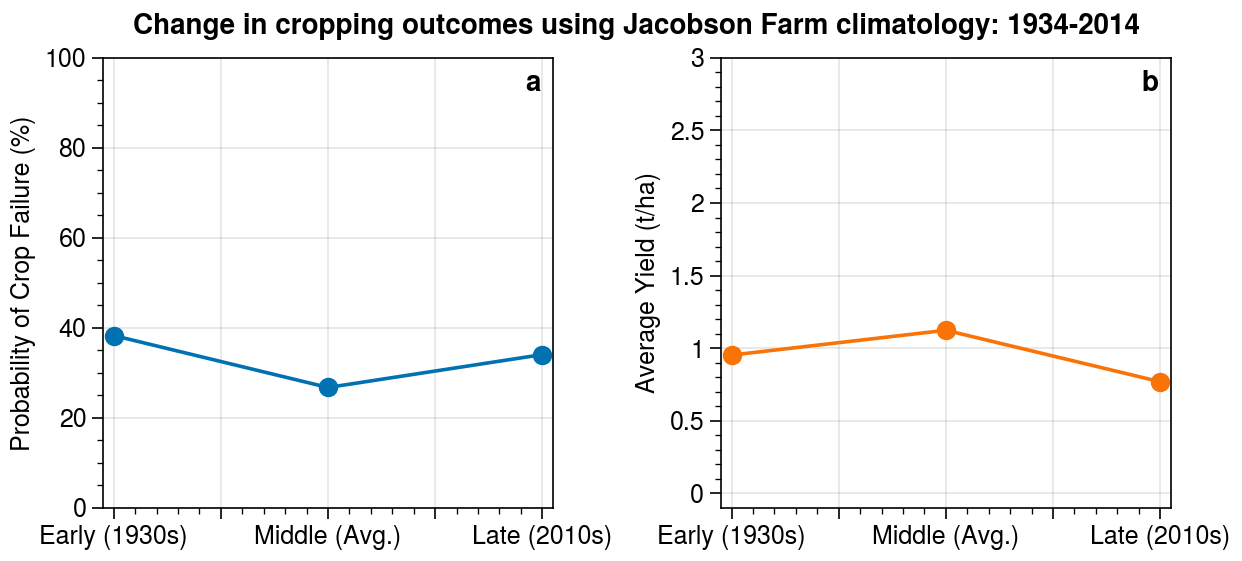

In [31]:
make_fig(table)

In [ ]:
# In the manuscript need to say more meaningful things about hwo small alpha and high lambda and large alpa and small lambda
# have roughly equivalent outcomes
# may have hit more of a sweet spot in the middle, but we're potentially beyind that 

In [32]:
# Let's add error bars

def double_std(array):
    return np.std(array) * 2

# let's turn zeros into nans
result_list['Yield'].replace(0, np.nan, inplace=True)
res = result_list.groupby('Era')['Yield'].agg([np.nanmean, double_std, st.sem]) # originally np.mean

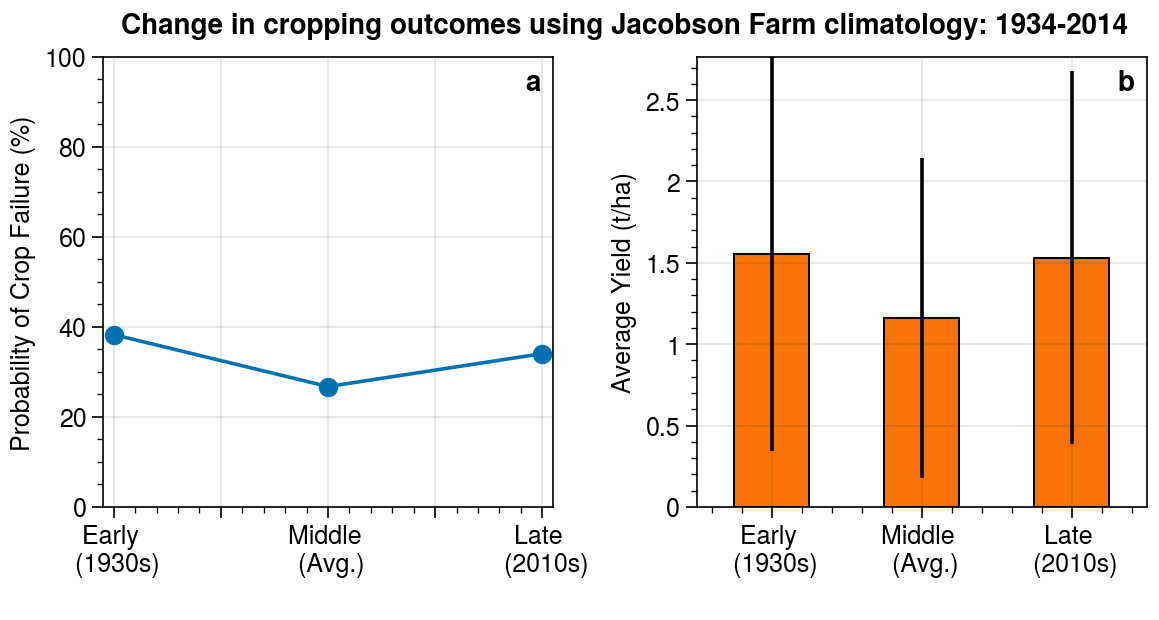

In [33]:
# New plot
f, ax = plot.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
ax.format(
         suptitle='Change in cropping outcomes using Jacobson Farm climatology: 1934-2014',
        abc=True, abcloc='ur'
     )

table['Probability of Crop Failure (%)'].plot(marker='o',markersize=6, ax=ax[0])
ax[0].set(ylim=(0,100))
ax[0].format(ylabel='Probability of Crop Failure (%)')
ax[0].set(xlim=(-0.05,2.05)) # -0.05,2.05
ax[0].set_xticklabels(['','Early \n (1930s)','',
                      'Middle \n (Avg.)','','Late \n (2010s)'])

res.plot(kind = "bar", y = "nanmean", yerr = "double_std",legend=False, ax=ax[1], color='orange') #  width=0.8, , title = "...",

#ax[1].set(ylim=(-0.1,3))
#ax[1].set(xlim=(-0.5,2.5))
ax[1].format(ylabel='Average Yield (t/ha)')


ax[1].set_xticklabels(['Early \n (1930s)',
                      'Middle \n (Avg.)','Late \n (2010s)'])
ax[1].tick_params(axis='x', labelrotation=0)

#plt.savefig('../output/results_11042020/past_cropfail_F2_.png')



## Use this figure?

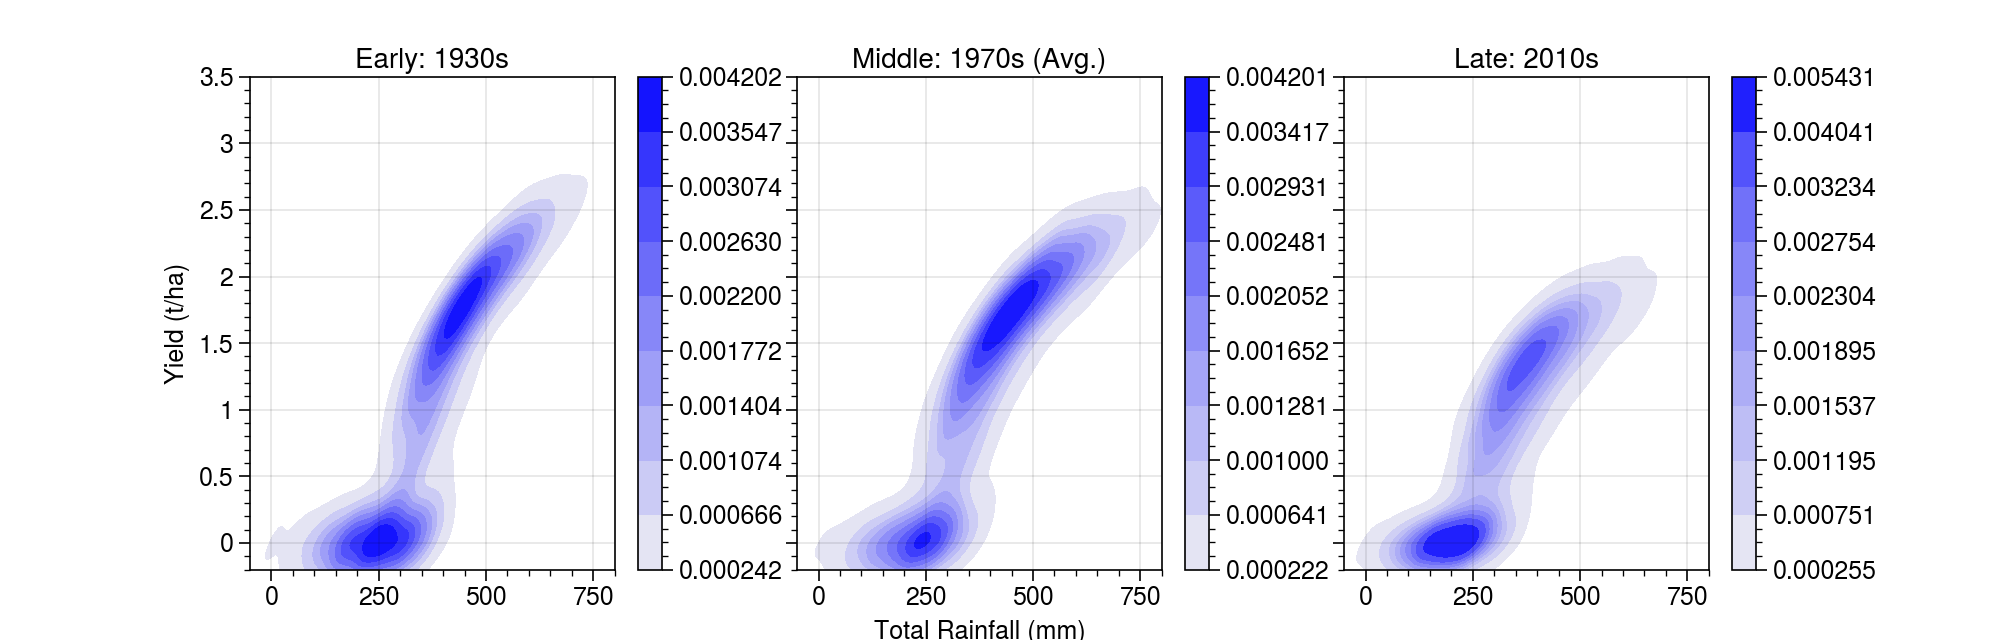

In [36]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3.2), sharey=True, sharex=True)

# Set colorscheme
blues = sns.color_palette("light:b", as_cmap=True)

# Draw plots
ax1 = ax[0]
sns.kdeplot(data=result_1930, x="RF", y="Yield", cmap=blues,cbar=True, shade = True,
            ax=ax1).set_title('Early: 1930s')

ax2 = ax[1]
sns.kdeplot(data=result, x="RF", y="Yield",cmap=blues, shade=True,
                 cbar=True,ax=ax2).set_title('Middle: 1970s (Avg.)')

ax3 = ax[2]
sns.kdeplot(data=result_2010, x="RF", y="Yield", cmap=blues, shade=True,
             cbar=True, ax=ax3).set_title('Late: 2010s')

# Set labels
ax1.set(xlabel='')
ax1.set(ylabel='Yield (t/ha)')
ax2.set(xlabel='Total Rainfall (mm)')
ax2.set(ylabel='')
ax3.set(ylabel='')
ax3.set(xlabel='')

# Set axes limits
for ax in [ax1, ax2, ax3]:
    ax.set(ylim=(-0.2,3.5))
    ax.set(xlim=(-50,800))


## Old code

In [ ]:
# Playing around with colormaps: https://seaborn.pydata.org/tutorial/color_palettes.html
test = sns.diverging_palette(250, 230, l=65, center="dark", as_cmap=True)
test = sns.color_palette("ch:start=.3,rot=-.3", as_cmap=True)
test1 = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
#test = sns.dark_palette("#69d", reverse=True, as_cmap=True)
test = sns.color_palette("Blues_r", as_cmap=True)

In [ ]:
sns.kdeplot(r2.RF, r2.Yield/1000, kind='kde',cmap=test, shade=True,
             cbar=True).set_title('Late: 2010s') #greens

In [ ]:
sns.kdeplot(r2.RF, r2.Yield/1000, kind='kde',cmap=test1, shade=True,
             cbar=True).set_title('Late: 2010s') #greens

In [ ]:
sns.kdeplot(r2.RF, r2.Yield/1000, kind='kde',cmap=test2, shade=True,
             cbar=True).set_title('Late: 2010s') #greens

In [ ]:

# Easier to manually import the values for slope and intercept
# These came from the regression line of seasonal trends for Jacobson Farm
# m_al = 0.06616878857577158 # Slope, alpha
# m_ll = -0.002652831781941007 # Slope, lambda

# c_al = -121.90153294377794 # Intercept, alpha
# c_ll = 5.578343185001898 # Intercept, lambda

In [ ]:
# alpha_r = a_mid
# lambda_r = l_mid
# n_sim = 100
# burn_in = 60
# station = 'JACOBSON FARM'
# data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv'
# texture = 'clay loam'
# lgp=180
# pd_sim=60
# interval='dekad'
# do_std=True

# soil = Soil(texture=texture)
    
# crop = Crop(soil=soil, lgp=lgp)
    
# soil.set_nZr(crop)

# model = CropModel(crop=crop, climate=s0_climate, soil=soil)

# # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
# n_burn_in_sims = max(10, int(n_sim*.10))

In [ ]:
# s0_climate = Climate(
#         data_file=data_file,
#         station=station,
#         interval=interval,
#         alpha_r=alpha_r, lambda_r=lambda_r,
#         do_std=do_std)

# models = [CropModel(
#                   crop=crop,
#                   climate=Climate(
#                       alpha_r=s0_climate.alpha_r,
#                       lambda_r=s0_climate.lambda_r,
#                       lambda_std=s0_climate.lambda_std,
#                       do_std=do_std),
#                   soil=soil) for i in np.arange(n_sim)
#                ]

# rain_stds = []

# for model in models: 
#     rain_stds.append(model.climate.rain_std)
    
# pd.DataFrame(rain_stds).plot(kind='hist')

# What happens when I make the alphas and lambdas really high. Do I still get the same outcome?
#a_mid

#a_mid = [100]*37
#l_mid = [0.5]*27

# Okay so now I know these alphas and lambdas are not being read in. 

# Let's try to chnange it as an argument in the function

# If that doesn't work then it's not changing within the code

In [ ]:

## Skipping ahead a little.. Going to import the other dataframes and see what shakes out

#result_1930 = pd.read_csv('result_1930.csv',sep=',').drop('Unnamed: 0', axis=1)
#result_2010 = pd.read_csv('result_2010.csv',sep=',').drop('Unnamed: 0', axis=1)
# result_list = [result_1930, result, result_2010]
# result_list = pd.concat(result_list)

# result_list

# Skipping ahead part 2

## Do table and plot
# table = pd.DataFrame({'Rainfall Climatology':['Early: 1930s','Middle: 1970s (Avg)','Late: 2010s'],
#                    # 'Rainfall Climatology':['1935-1940','1972-1977','2010-2015']
#             'Maize Variety':[180,180,180],
#             'Average Alpha (mm)':[mean(alphas_1930), mean(a_mid), mean(alphas_2010)],
#             'Average Lambda (day^-1)':[mean(lambdas_1930), mean(l_mid), mean(lambdas_2010)],
#             'Average Rainfall (mm)':[result_1930.RF.mean(), result.RF.mean(), result_2010.RF.mean()],
#             'SD Rainfall':[np.std(result_1930.RF),np.std(result.RF),np.std(result_2010.RF)],
#             'CV Rainfall':[result_1930.RF.std()/result_1930.RF.mean(), 
#                                 result.RF.std()/result.RF.mean(),
#                                 result_2010.RF.std()/result_2010.RF.mean()],
#             'Average Yield (t/ha)': [np.nanmean(result_1930.Yield), 
#                                      np.nanmean(result.Yield), 
#                                      np.nanmean(result_2010.Yield)],
#             'Probability of Crop Failure (%)':[len(result_1930.loc[result_1930['Yield'] == 0].count(axis=1))/len(result_1930)*100,
#                                                len(result.loc[result['Yield'] == 0].count(axis=1))/len(result)*100,
#                                                len(result_2010.loc[result_2010['Yield'] == 0].count(axis=1))/len(result_2010)*100]})
# table

# Jacobson Farm reainfall is 744 for the whole year, so 389 average for half a year is about right 